<a href="https://colab.research.google.com/github/samarakoon-ryan/Grovers-Algorithm/blob/sim-experiment/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Grover's Algorithm using IBM Qiskit

## Install Dependencies

In [9]:
# pip installs Qiskit
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-_8t2nzkp
  Running command git clone -q https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-_8t2nzkp
     |████████████████████████████████| 1.6 MB 33.0 MB/s 
     |████████████████████████████████| 6.7 MB 50.6 MB/s 
     |████████████████████████████████| 19.2 MB 349 kB/s 
     |████████████████████████████████| 240 kB 68.7 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 112 kB 78.1 MB/s 
     |████████████████████████████████| 943 kB 69.6 MB/s 
     |████████████████████████████████| 37.5 MB 17 kB/s 
     |████████████████████████████████| 49 kB 9.1 MB/s 
     |████████████████████████████████| 49 kB 9.3 MB/s 
     |████████████████████████████████| 1.6 MB 62.7 MB/s 
     |████████████████████████████████| 4.0 MB 43.2 MB/s 


In [15]:
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

## 2 Qubit Example

We will be searching for |
w
⟩
 [3]

### Initialize the state

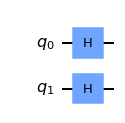

In [23]:
# We prepare a quantum circuit with 2 qubits
n = 2
grovers_circuit = QuantumCircuit(n)

# We then apply an H-gate to each qubit in order for it to get into 
# a superposition state. The default initial state is |0> so 
# H|0> = |+>

def initialize_superposition(qc, qubits):
    """Apply an H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

# The above function is used to initialize our circuit
grovers_circuit = initialize_superposition(grovers_circuit, [0,1])
grovers_circuit.draw(output='mpl')

### Oracle

- Oracle for  |ω⟩ = |11⟩

- This is essentially a controlled Z-gate, so for this example the oracle is simply the controlled Z-gate.
 

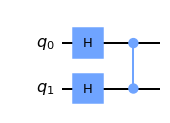

In [24]:
# Apply the Oracle
grovers_circuit.cz(0,1) # Z-gate that joins Qubit 0 and Qubit 1
grovers_circuit.draw(output='mpl')


### Diffuser

- We will apply the diffusion operator to both qubits.
- This includes an H-gate, Z-gate, controlled Z-gate, and another H-gate.

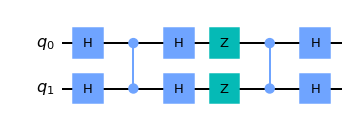

In [25]:
# Diffusion operator
grovers_circuit.h([0,1])
grovers_circuit.z([0,1])
grovers_circuit.cz(0,1)
grovers_circuit.h([0,1])
grovers_circuit.draw(output='mpl')

This is the finished circuit!

## Simulation Experiment

First, we will verify that we have the correct statevector.

In [26]:
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grovers_circuit_sim = grovers_circuit.copy()
grovers_circuit_sim.save_statevector()
qobj = assemble(grovers_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import array_to_latex
array_to_latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

We then verify the probability of measuring |11⟩ and all other states. It should be 100% for |11⟩ and 0% for all others.



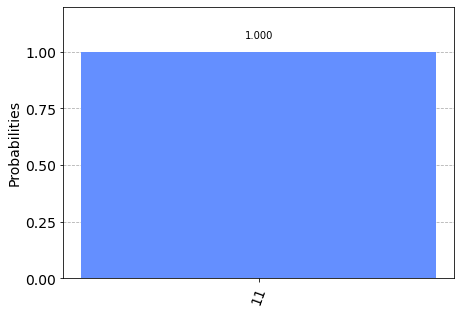

In [27]:
# We measure all the qubits and then use the simulator to get probabilities
grovers_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grovers_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
#